# Importing Neccessary Libraries

In [1]:
!pip install scikeras
!pip install catboost
!pip uninstall scikit-learn --yes
!pip uninstall imblearn --yes
!pip install scikit-learn==1.2.2
!pip install imblearn

  Using cached scikit_learn-1.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Found existing installation: scikit-learn 1.5.0
Uninstalling scikit-learn-1.5.0:
  Successfully uninstalled scikit-learn-1.5.0
Found existing installation: imblearn 0.0
Uninstalling imblearn-0.0:
  Successfully uninstalled imblearn-0.0
  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.2.2 which is incompatible.
  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)


In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_curve, auc, confusion_matrix,
    roc_auc_score, precision_recall_curve
)
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids, NearMiss
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import layers

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set a Random State value
RANDOM_STATE = 42

# Set Python random a fixed value
import random
random.seed(RANDOM_STATE)

# Set numpy random a fixed value
import numpy as np
np.random.seed(RANDOM_STATE)

# Reading File

In [3]:
data = pd.read_excel('fraud_oracle.xlsx')
data.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


# Basic Exploration

In [4]:
data.shape

(15420, 33)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound            15420 non-null

In [6]:
data.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


In [7]:
data.describe(include='object')

,Month,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,Sex,MaritalStatus,Fault,PolicyType,...,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,BasePolicy
count,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420,...,15420,15420,15420,15420,15420,15420,15420,15420,15420,15420
unique,12,7,19,2,8,13,2,4,2,9,...,4,8,9,2,2,2,4,5,5,3
top,Jan,Monday,Pontiac,Urban,Monday,Jan,Male,Married,Policy Holder,Sedan - Collision,...,2 to 4,7 years,31 to 35,No,No,External,none,no change,1 vehicle,Collision
freq,1411,2616,3837,13822,3757,1446,13000,10625,11230,5584,...,5485,5807,5593,14992,15333,15179,7047,14324,14316,5962


## - Uniuqe Values

In [8]:
for i in data.columns:
    print(i, end=" ")
    if data[i].nunique()>20:
        print(f'{data[i].unique()[:10]} . . .')
    else:
        print(f'{data[i].unique()}')
    print("="*50,end="\n\n")

Month ['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Nov' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep']

WeekOfMonth [5 3 2 4 1]

DayOfWeek ['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']

Make ['Honda' 'Toyota' 'Ford' 'Mazda' 'Chevrolet' 'Pontiac' 'Accura' 'Dodge'
 'Mercury' 'Jaguar' 'Nisson' 'VW' 'Saab' 'Saturn' 'Porche' 'BMW' 'Mecedes'
 'Ferrari' 'Lexus']

AccidentArea ['Urban' 'Rural']

DayOfWeekClaimed ['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday'
 '0']

MonthClaimed ['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct'
 '0']

WeekOfMonthClaimed [1 4 2 3 5]

Sex ['Female' 'Male']

MaritalStatus ['Single' 'Married' 'Widow' 'Divorced']

Age [21 34 47 65 27 20 36  0 30 42] . . .

Fault ['Policy Holder' 'Third Party']

PolicyType ['Sport - Liability' 'Sport - Collision' 'Sedan - Liability'
 'Utility - All Perils' 'Sedan - All Perils' 'Sedan - Collision'
 'Utility - Collision' 'Utility - Liability' 'Sport - All Perils']

VehicleCategory ['S

## Missing Values

In [9]:
for i in data.columns:
    if i != 'FraudFound':
        missing_values = data[i].isna().sum() + len(data[data[i]=='none']) + len(data[data[i]=='0'])
        missing_percent = round((missing_values/len(data))*100,2)
        if missing_percent > 0:
            print(f'{i}: ',end="----------------------")
            print(f'{missing_percent}%')


DayOfWeekClaimed: ----------------------0.01%
MonthClaimed: ----------------------0.01%
Days:Policy-Accident: ----------------------0.36%
Days:Policy-Claim: ----------------------0.01%
PastNumberOfClaims: ----------------------28.22%
NumberOfSuppliments: ----------------------45.7%


- For `PastNumberOfClaims` and `NumberOfSuppliments` 'none' act as a category itself
- We will drop for rest of features

In [10]:
data.drop(data[data['MonthClaimed'] == '0'].index, inplace=True)
data.drop(data[data['DayOfWeekClaimed'] == '0'].index, inplace=True)

data.drop(data[data['Days:Policy-Accident'] == 'none'].index, inplace=True)
data.drop(data[data['Days:Policy-Claim'] == 'none'].index, inplace=True)

- We will drop `PolicyNumber` and `RepNumber` as they are irrelavant

In [11]:
data.drop(['PolicyNumber','RepNumber'],axis=1,inplace=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15364 entries, 0 to 15419
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15364 non-null  object
 1   WeekOfMonth           15364 non-null  int64 
 2   DayOfWeek             15364 non-null  object
 3   Make                  15364 non-null  object
 4   AccidentArea          15364 non-null  object
 5   DayOfWeekClaimed      15364 non-null  object
 6   MonthClaimed          15364 non-null  object
 7   WeekOfMonthClaimed    15364 non-null  int64 
 8   Sex                   15364 non-null  object
 9   MaritalStatus         15364 non-null  object
 10  Age                   15364 non-null  int64 
 11  Fault                 15364 non-null  object
 12  PolicyType            15364 non-null  object
 13  VehicleCategory       15364 non-null  object
 14  VehiclePrice          15364 non-null  object
 15  FraudFound            15364 non-null  obj

# Exploratory Data Analysis

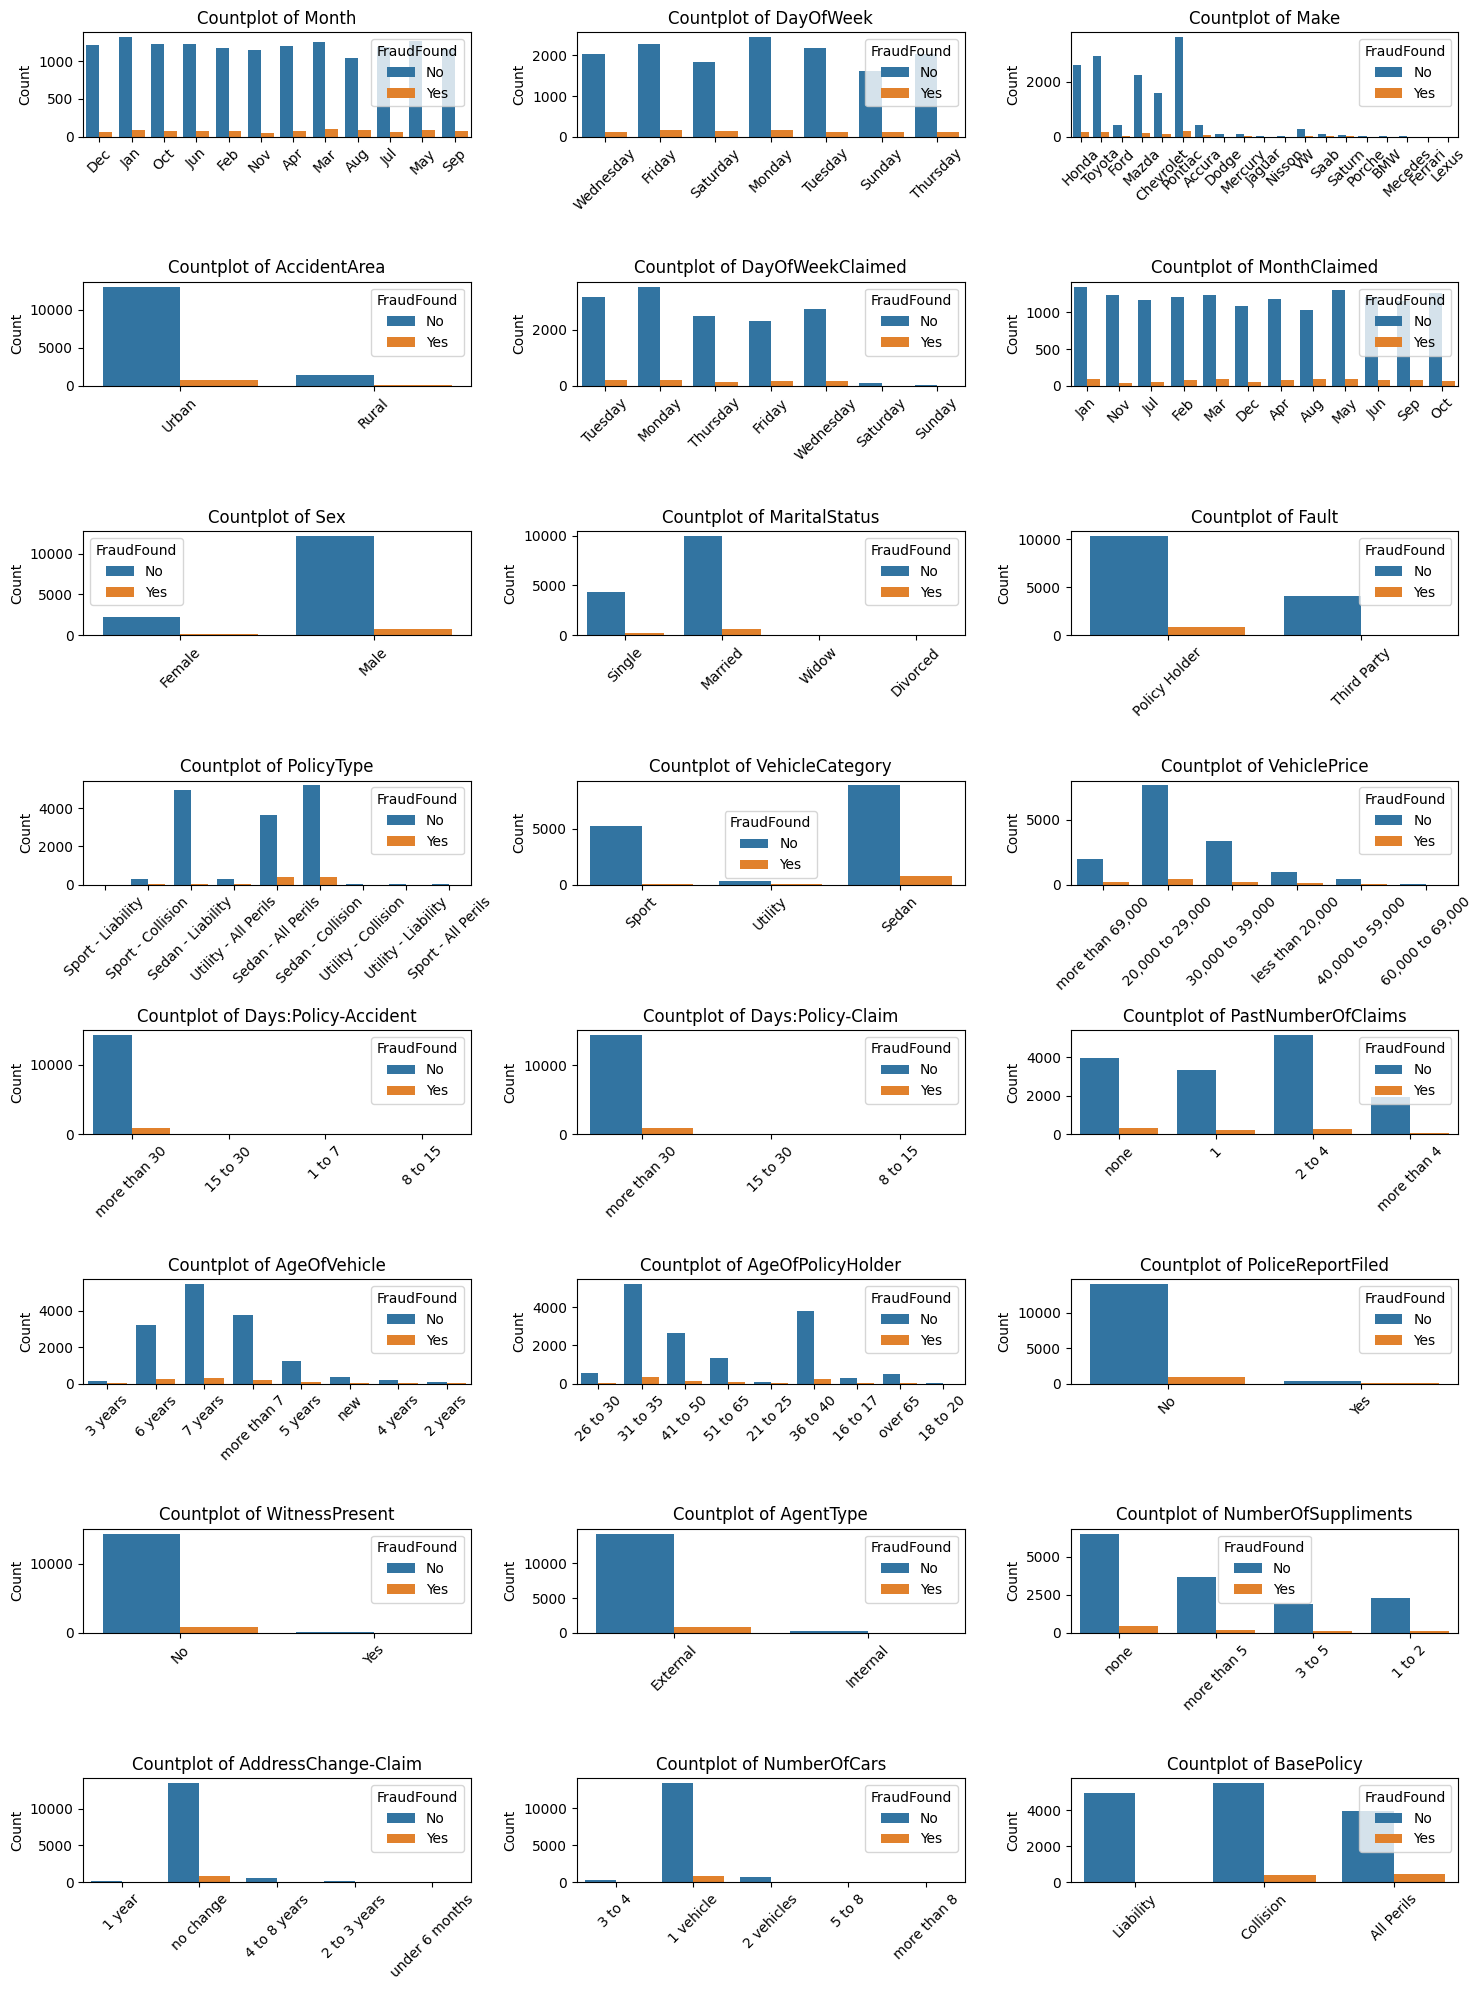

In [13]:
features = [i  for i in data.columns if data[i].dtype==object and i != 'FraudFound']

# Calculate the number of rows and columns for the grid
num_rows = 8
num_cols = 3

# Create subplots with the specified layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))
plt.subplots_adjust(wspace=0.4, hspace=0.5)

# Loop through features and create countplots in the subplots
for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    sns.countplot(x=feature, data=data, ax=ax,hue='FraudFound')
    ax.set_title(f'Countplot of {feature}')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Hide any empty subplots
for i in range(len(features), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

- We can see that for some  features only one category is dominatiing and rest of the categories are limited in numbers
- Lets see their distribution % wise

In [14]:
for i in features:
    print(i)
    print(round(data[i].value_counts()/len(data)*100,2))
    print("="*50)

Month
Month
Jan    9.16
May    8.86
Mar    8.81
Jun    8.57
Oct    8.47
Dec    8.32
Apr    8.32
Feb    8.19
Jul    8.14
Sep    8.06
Nov    7.80
Aug    7.32
Name: count, dtype: float64
DayOfWeek
DayOfWeek
Monday       16.97
Friday       15.84
Tuesday      14.92
Thursday     14.09
Wednesday    14.01
Saturday     12.87
Sunday       11.30
Name: count, dtype: float64
Make
Make
Pontiac      24.88
Toyota       20.24
Honda        18.15
Mazda        15.28
Chevrolet    10.91
Accura        3.06
Ford          2.92
VW            1.84
Dodge         0.70
Saab          0.70
Mercury       0.54
Saturn        0.38
Nisson        0.20
BMW           0.10
Jaguar        0.04
Porche        0.03
Mecedes       0.03
Ferrari       0.01
Lexus         0.01
Name: count, dtype: float64
AccidentArea
AccidentArea
Urban    89.64
Rural    10.36
Name: count, dtype: float64
DayOfWeekClaimed
DayOfWeekClaimed
Monday       24.39
Tuesday      21.90
Wednesday    19.12
Thursday     17.25
Friday       16.19
Saturday      0.82
Sund

- After exploring we decide to remove those category that are less than 7% in our data for each feature
- If after removing, there exists only one category we will drop that feature only

## Retaining Relevant Features based on frequecny

In [15]:
df = data.copy(deep=True)
for feature in features:
    value_percent = round(data[feature].value_counts()/len(data)*100,2)
    values_to_remove = value_percent[value_percent <=7].index
    df = df[~df[feature].isin(values_to_remove)]

for feature in features:
    unique_classes = df[feature].nunique()
    if unique_classes <= 1:
        df.drop(columns=[feature], inplace=True)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9593 entries, 11 to 15415
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Month                9593 non-null   object
 1   WeekOfMonth          9593 non-null   int64 
 2   DayOfWeek            9593 non-null   object
 3   Make                 9593 non-null   object
 4   AccidentArea         9593 non-null   object
 5   DayOfWeekClaimed     9593 non-null   object
 6   MonthClaimed         9593 non-null   object
 7   WeekOfMonthClaimed   9593 non-null   int64 
 8   Sex                  9593 non-null   object
 9   MaritalStatus        9593 non-null   object
 10  Age                  9593 non-null   int64 
 11  Fault                9593 non-null   object
 12  PolicyType           9593 non-null   object
 13  VehicleCategory      9593 non-null   object
 14  VehiclePrice         9593 non-null   object
 15  FraudFound           9593 non-null   object
 16  Deductibl

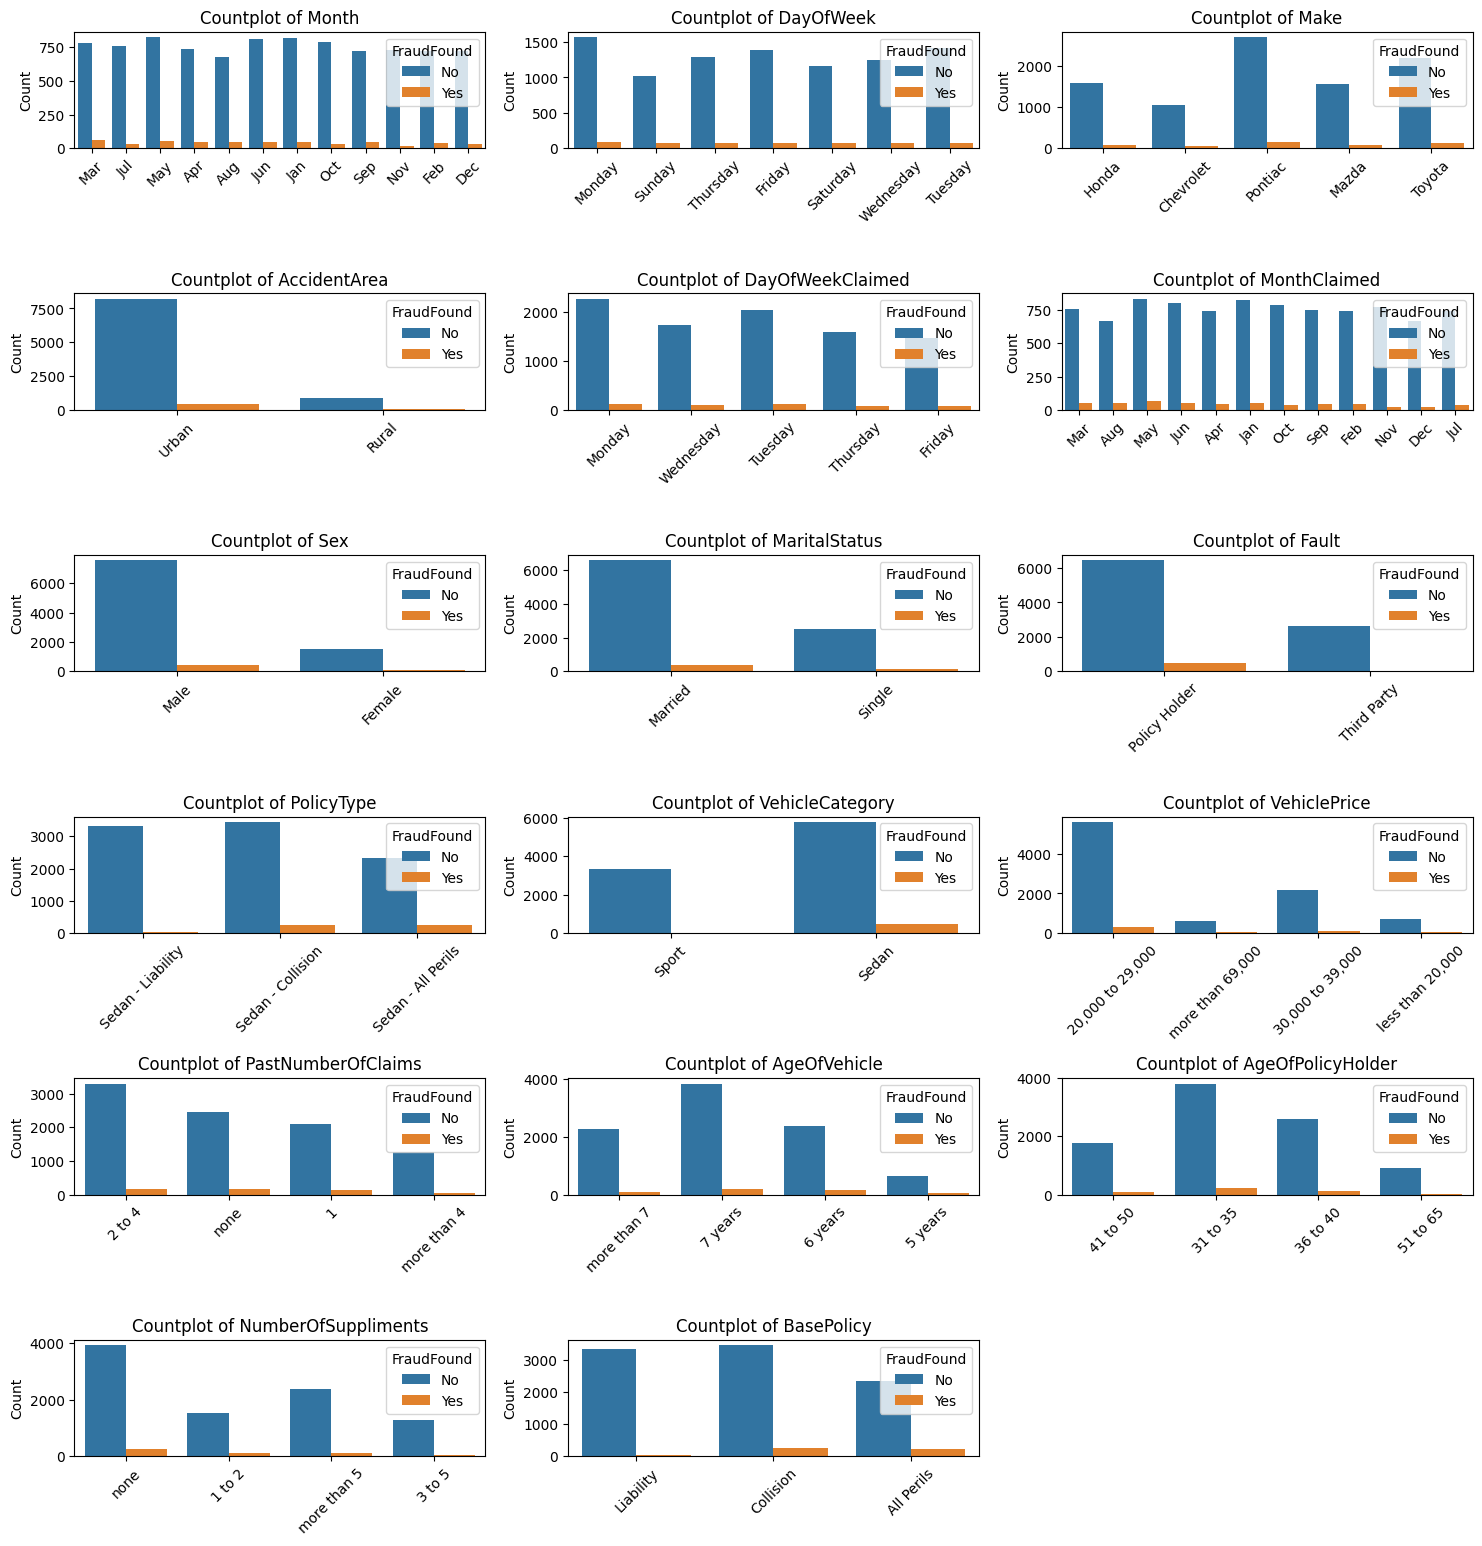

In [17]:
features = [i  for i in df.columns if df[i].dtype==object and i != 'FraudFound']
num_rows = 8
num_cols = 3

# Create subplots with the specified layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))
plt.subplots_adjust(wspace=0.4, hspace=0.5)

# Loop through features and create countplots in the subplots
for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    sns.countplot(x=feature, data=df, ax=ax,hue='FraudFound')
    ax.set_title(f'Countplot of {feature}')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Hide any empty subplots
for i in range(len(features), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# Feature Engineering

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9593 entries, 11 to 15415
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Month                9593 non-null   object
 1   WeekOfMonth          9593 non-null   int64 
 2   DayOfWeek            9593 non-null   object
 3   Make                 9593 non-null   object
 4   AccidentArea         9593 non-null   object
 5   DayOfWeekClaimed     9593 non-null   object
 6   MonthClaimed         9593 non-null   object
 7   WeekOfMonthClaimed   9593 non-null   int64 
 8   Sex                  9593 non-null   object
 9   MaritalStatus        9593 non-null   object
 10  Age                  9593 non-null   int64 
 11  Fault                9593 non-null   object
 12  PolicyType           9593 non-null   object
 13  VehicleCategory      9593 non-null   object
 14  VehiclePrice         9593 non-null   object
 15  FraudFound           9593 non-null   object
 16  Deductibl

In [19]:
def feature_engineering(df):

    binary_features = [i for i in df.columns if df[i].nunique() == 2]

    # Initialize a LabelEncoder instance
    label_encoder = LabelEncoder()

    # Iterate through each binary feature and apply label encoding
    for feature in binary_features:
        # Fit the label encoder and transform the feature values
        df[feature] = label_encoder.fit_transform(df[feature])


    '''
    This code calculates and applies frequency encoding to the specified columns (months_weeks)
    based on the occurrence of each category in the dataset for both classes of the target variable
    (FraudFound = 1 and FraudFound = 0). The calculated frequency encoding values are then mapped
    to the respective columns in the DataFrame. This technique can be used to encode categorical
    features based on the relative frequencies of their categories in different target classes.

    '''

    # List of columns for frequency encoding
    months_weeks = ['WeekOfMonth', 'Month', 'DayOfWeek', 'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed']

    # Iterate through each column for frequency encoding
    for column in months_weeks:
        # Calculate the frequency of each category for FraudFound=1 and FraudFound=0
        freq_1 = df[df['FraudFound'] == 1].groupby(column).size() / len(df)
        freq_0 = df[df['FraudFound'] == 0].groupby(column).size() / len(df)

        # Calculate the frequency encoding value using the formula (15*freq_1 + freq_0) / 2
        freq_encoding = (15 * freq_1 + freq_0) / 2

        # Map the calculated frequency encoding values to the respective column in the DataFrame
        df[column] = df[column].map(freq_encoding)


    #Encoding AgeOfPolicyHolder
    age_mapping = {
        '31 to 35': 0,
        '36 to 40': 1,
        '41 to 50': 2,
        '51 to 65': 3
    }

    df['AgeOfPolicyHolder'] = df['AgeOfPolicyHolder'].map(age_mapping)



    #Encoding VehiclePrice
    encoding_mp = {
        '20,000 to 29,000': 1,
        'more than 69,000': 3,
        '30,000 to 39,000': 2,
        'less than 20,000': 0
    }
    df['VehiclePrice'] = df['VehiclePrice'].map(encoding_mp).fillna(-1)


    #Encoding AgeOfVehicle
    age_mapping = {
        '7 years': 2,
        '6 years': 1,
        'more than 7': 3,
        '5 years': 0
    }

    df['AgeOfVehicle'] = df['AgeOfVehicle'].map(age_mapping)


    #Encoding NumberOfSuppliments
    suppliments_mapping = {
        'none': 0,
        'more than 5': 3,
        '1 to 2': 1,
        '3 to 5': 2
    }

    df['NumberOfSuppliments'] = df['NumberOfSuppliments'].map(suppliments_mapping)


    # Encoding PastNumberOfClaims
    claim_mapping = {
        '2 to 4': 2,
        'none': 0,
        '1': 1,
        'more than 4': 3
    }

    df['PastNumberOfClaims'] = df['PastNumberOfClaims'].map(claim_mapping)

In [20]:
feature_engineering(df)

# Correlation Analysis

<Axes: >

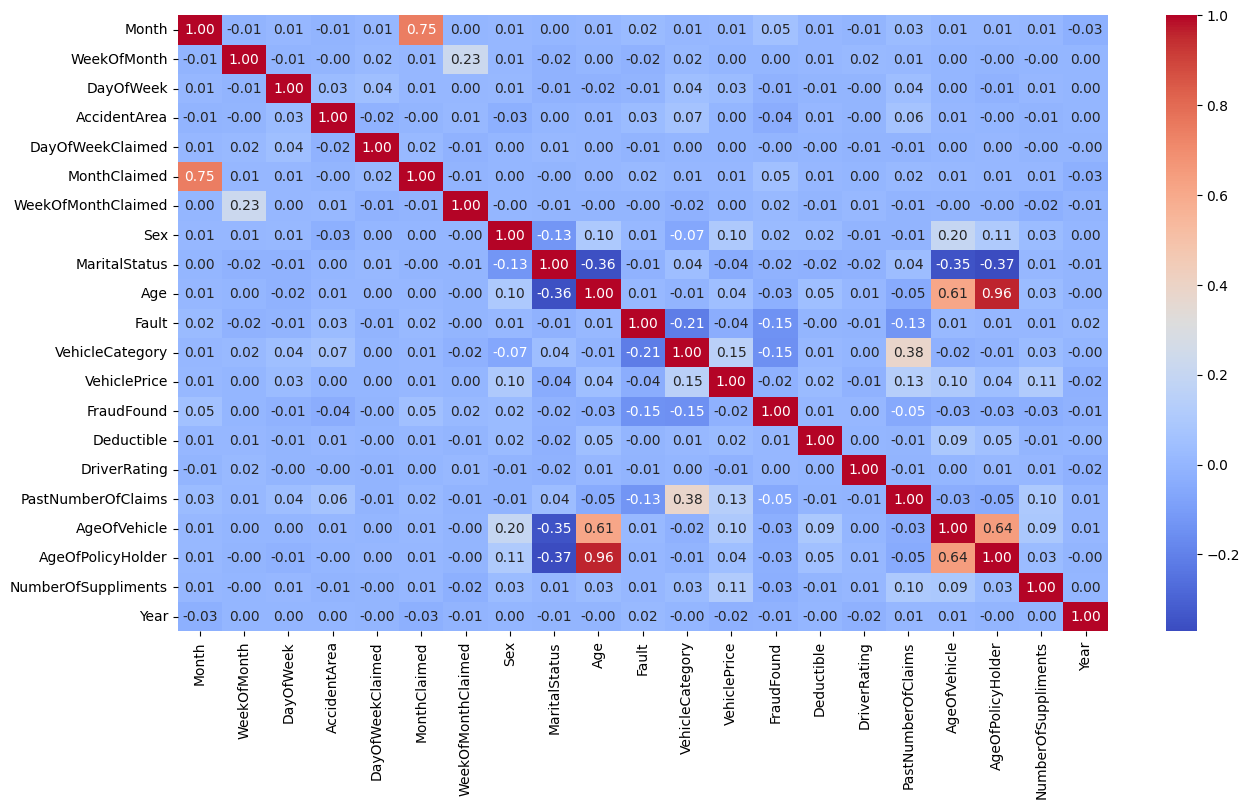

In [21]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f")

-  Age is highly correlated with Age of Policy Holder. We will remove it

In [22]:
df.drop('Age',axis=1,inplace=True)

## Correlation with Target

Text(0.5, 1.0, 'Correlation w.r.t FraudFound')

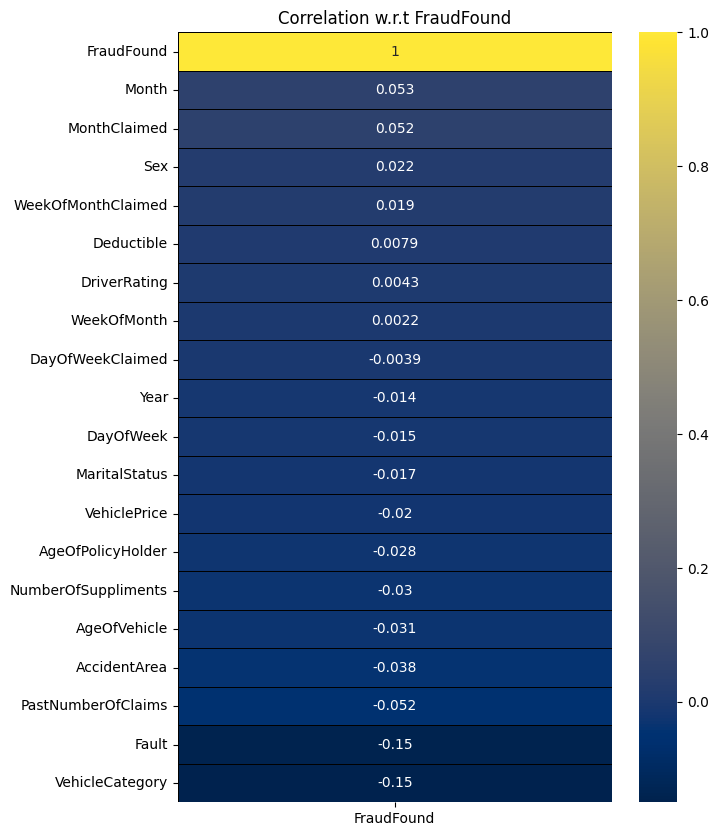

In [23]:
feautre_sel_df = df
corr = feautre_sel_df.corrwith(feautre_sel_df['FraudFound'],numeric_only=True).sort_values(ascending = False).to_frame()
corr.columns = ['FraudFound']
plt.subplots(figsize = (7,10))
sns.heatmap(corr,annot = True,cmap='cividis',linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t FraudFound')

# Chi-Square Test

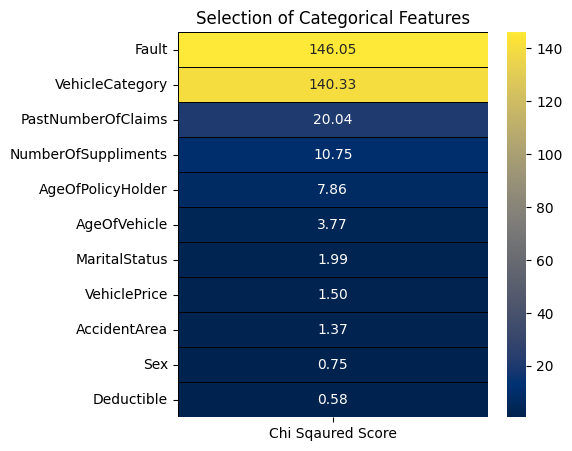

In [24]:
from sklearn.feature_selection import SelectKBest,chi2,f_classif

categorical_features = ['AgeOfPolicyHolder','VehiclePrice','AgeOfVehicle','NumberOfSuppliments','PastNumberOfClaims','AccidentArea','Sex','MaritalStatus','Fault','VehicleCategory','Deductible']
features = df.loc[:,categorical_features]
target = pd.DataFrame(df['FraudFound'])

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Sqaured Score'])

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Sqaured Score'),annot = True,cmap = 'cividis',linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features');

# ANOVA Test

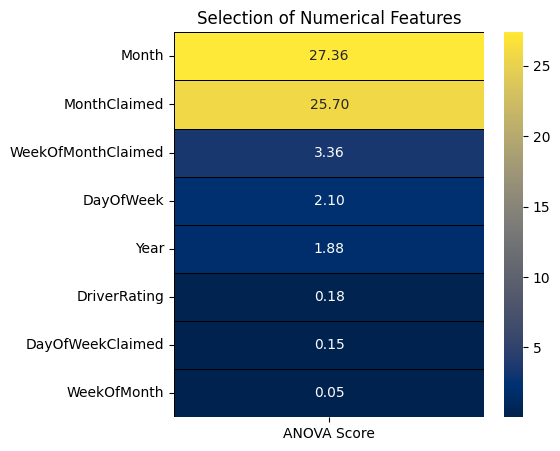

In [25]:
numerical_features = [i for i in df.columns if i not in categorical_features and i not in ['Make','PolicyType','BasePolicy','FraudFound']]
features = df.loc[:,numerical_features]
target = pd.DataFrame(df['FraudFound'])

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score'])

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = 'cividis',linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

# Final Dataset

In [26]:
def get_final_data(df):
    df.drop(['WeekOfMonth','DayOfWeekClaimed','DriverRating','Deductible','Sex','AccidentArea','VehiclePrice','MaritalStatus','AgeOfVehicle','Make'],axis=1,inplace=True)
    df = pd.get_dummies(df,columns=['PolicyType','BasePolicy'],drop_first=True)
    return df

df = get_final_data(df)

In [27]:
df.head()

,Month,DayOfWeek,MonthClaimed,WeekOfMonthClaimed,Fault,VehicleCategory,FraudFound,PastNumberOfClaims,AgeOfPolicyHolder,NumberOfSuppliments,Year,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,BasePolicy_Collision,BasePolicy_Liability
11,0.088346,0.145783,0.078703,0.061086,0,1,0,2,2,0,1994,False,True,False,True
17,0.063119,0.106484,0.073074,0.197019,1,0,0,0,0,1,1994,True,False,True,False
18,0.085166,0.119202,0.093558,0.061086,0,1,0,1,0,0,1994,False,True,False,True
19,0.076827,0.145783,0.093558,0.197019,1,1,0,2,0,3,1994,False,True,False,True
20,0.076827,0.130512,0.093558,0.197019,0,1,0,1,1,3,1994,False,True,False,True


In [28]:
df.shape

(9593, 15)

In [29]:
df.reset_index(inplace=True)

# Features and Labels

In [30]:
X = df.drop(['FraudFound'],axis=1)
y = df['FraudFound']

In [31]:
y.value_counts()

FraudFound
0    9093
1     500
Name: count, dtype: int64

# Splitting the data

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [33]:
y_train.value_counts()

FraudFound
0    7274
1     400
Name: count, dtype: int64

# Normalization

In [34]:
norm = MinMaxScaler()
X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

# ANN for Binary Classification

In [35]:
def ann():
    model = keras.Sequential([
    layers.Input(shape=(15,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),  # Add dropout layer
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),  # Add dropout layer
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_ann(X_train, y_train, X_test, y_test, sampling_technique,class_weights=None,param_grid=None):

    model = KerasClassifier(build_fn=ann, epochs=10)

    model.fit(X_train, y_train, epochs=10, batch_size=32,class_weight=class_weights,verbose=0)

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = [1 if i>0.7 else 0 for i in y_pred]
    y_pred_proba = model.predict_proba(X_test)
    # Since predict_proba returns probabilities for both classes, we use [:, 1] to get the probabilities for class 1
    y_pred_proba_class1 = y_pred_proba[:, 1]
    # Predict class labels based on probability threshold
    # Calculate the AUC score
    auc = roc_auc_score(y_test, y_pred_proba_class1)

    # Print classification report
   # print("Classification Report:")
   # print(classification_report(y_test, y_pred_classes))

    cm = confusion_matrix(y_test, y_pred)

    rf_Recall = round(recall_score(y_test, y_pred)*100,2)
    rf_Precision = round(precision_score(y_test, y_pred)*100,2)
    rf_f1 = round(f1_score(y_test, y_pred)*100,2)
    rf_accuracy = round(accuracy_score(y_test, y_pred)*100,2)
    rf_auc = round(auc * 100, 2)

    metrics = [sampling_technique,rf_accuracy, rf_Precision, rf_Recall, rf_f1, rf_auc]

    return metrics

# Training on different sampling techniques to handle imbalanced dataset

In [36]:
results = {}

#No Sampling
metrics = train_ann(X_train,y_train,X_test,y_test,'No Sampling')
results[metrics[0]] = metrics[1:]

#Cost Sensitive
metrics = train_ann(X_train,y_train,X_test,y_test,'Cost Sensitive',{0:1,1:18})
results[metrics[0]] = metrics[1:]

#RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_train, y_train)
metrics = train_ann(X_over, y_over, X_test, y_test,'RandomOverSampler')
results[metrics[0]] = metrics[1:]


#RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)
metrics = train_ann(X_under, y_under, X_test, y_test,'RandomUnderSampler')
results[metrics[0]] = metrics[1:]



#SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
metrics = train_ann(X_smote, y_smote, X_test, y_test,'SMOTE')
results[metrics[0]] = metrics[1:]



#TomekLinks
tomekU = TomekLinks()
X_underT, y_underT = tomekU.fit_resample(X_train, y_train)
metrics = train_ann(X_underT, y_underT, X_test, y_test,'TomekLinks')
results[metrics[0]] = metrics[1:]


#SMOTETomek
smoteT = SMOTETomek(random_state=42)
X_smoteT, y_smoteT = smoteT.fit_resample(X_train, y_train)
metrics = train_ann(X_smoteT, y_smoteT, X_test, y_test,'SMOTETomek')
results[metrics[0]] = metrics[1:]

# ADASYN (Adaptive Synthetic Sampling)
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
metrics_adasyn = train_ann(X_adasyn, y_adasyn, X_test, y_test, 'ADASYN')
results[metrics_adasyn[0]] = metrics_adasyn[1:]

# Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_borderline, y_borderline = borderline_smote.fit_resample(X_train, y_train)
metrics_borderline = train_ann(X_borderline, y_borderline, X_test, y_test, 'BorderlineSMOTE')
results[metrics_borderline[0]] = metrics_borderline[1:]

# SMOTE-ENN (SMOTE + Edited Nearest Neighbors)
smote_enn = SMOTEENN(random_state=42)
X_smote_enn, y_smote_enn = smote_enn.fit_resample(X_train, y_train)
metrics_smote_enn = train_ann(X_smote_enn, y_smote_enn, X_test, y_test, 'SMOTEENN')
results[metrics_smote_enn[0]] = metrics_smote_enn[1:]

cluster_centroids = ClusterCentroids(random_state=42)
X_cluster, y_cluster = cluster_centroids.fit_resample(X_train, y_train)
metrics_cluster = train_ann(X_cluster, y_cluster, X_test, y_test, 'ClusterCentroids')
results[metrics_cluster[0]] = metrics_cluster[1:]

# NearMiss
near_miss = NearMiss(version=1)
X_near_miss, y_near_miss = near_miss.fit_resample(X_train, y_train)
metrics_near_miss = train_ann(X_near_miss, y_near_miss, X_test, y_test, 'NearMiss')
results[metrics_near_miss[0]] = metrics_near_miss[1:]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# Results of ANN on different sampling techniques

In [37]:
sampling_techniques = list(results.keys())
metrics = ['Accuracy', 'Precision','Recall','F1 Score','AUC' ]
results_df = pd.DataFrame.from_dict(results, orient='index', columns=metrics)
Ann_df = results_df.sort_values(by=['F1 Score','AUC', 'Precision', 'Recall', 'Accuracy'], ascending=False)
Ann_df

,Accuracy,Precision,Recall,F1 Score,AUC
SMOTE,73.48,13.55,76.0,23.00,82.66
SMOTEENN,69.62,13.13,86.0,22.78,83.85
BorderlineSMOTE,74.88,13.55,71.0,22.76,82.21
SMOTETomek,67.85,12.59,87.0,22.00,82.65
Cost Sensitive,65.61,12.37,92.0,21.80,84.24
ADASYN,69.57,12.54,81.0,21.72,82.17
RandomOverSampler,67.90,12.28,84.0,21.43,83.07
RandomUnderSampler,63.42,11.99,95.0,21.30,83.38
ClusterCentroids,63.21,11.74,93.0,20.85,84.09
NearMiss,18.08,3.54,56.0,6.65,25.32


- Evaluation of sampling techniques in an Artificial Neural Network (ANN) highlighted the trade-off between capturing positive instances and minimizing false positives. Techniques like "BorderlineSMOTE" and "ADASYN" excelled in recall but showed lower precision, while "RandomUnderSampler" and "NearMiss" achieved high precision but compromised recall

# Funciton definition to train classifiers

In [38]:
def train_classifier(X_train, y_train, X_test, y_test, sampling_technique, model, param_grid=None, class_weights=None):
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    if class_weights:
        model.class_weight = class_weights

    if param_grid:
        clf = GridSearchCV(model, param_grid=param_grid, cv=kf, scoring='recall').fit(X_train, y_train)
    else:
        clf = model
        clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    # Predict probabilities on the test set for AUC calculation
    if hasattr(clf, "predict_proba"):
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = clf.decision_function(X_test)

    # Calculate the AUC score
    auc = roc_auc_score(y_test, y_pred_proba)

    cm = confusion_matrix(y_test, y_pred)

    classifier_Recall = round(recall_score(y_test, y_pred) * 100, 2)
    classifier_Precision = round(precision_score(y_test, y_pred) * 100, 2)
    classifier_f1 = round(f1_score(y_test, y_pred) * 100, 2)
    classifier_accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    auc_rounded = round(auc * 100, 2)

    metrics = [sampling_technique,classifier_accuracy, classifier_Precision, classifier_Recall, classifier_f1,  auc_rounded]

    return metrics

## Function definition to test different sampling techniques

In [39]:
def sampling_results(X_train,y_train,X_test,y_test,model, param_grid=None):
    results = {}

    #No Sampling
    metrics = train_classifier(X_train,y_train,X_test,y_test,'No Sampling',model, param_grid)
    results[metrics[0]] = metrics[1:]

    #Cost Sensitive
    metrics = train_classifier(X_train,y_train,X_test,y_test,'Cost Sensitive',model,param_grid,{0:1,1:18})
    results[metrics[0]] = metrics[1:]

    #RandomOverSampler
    ros = RandomOverSampler(random_state=42)
    X_over, y_over = ros.fit_resample(X_train, y_train)
    metrics = train_classifier(X_over, y_over, X_test, y_test,'RandomOverSampler',model, param_grid)
    results[metrics[0]] = metrics[1:]


    #RandomUnderSampler
    rus = RandomUnderSampler(random_state=42)
    X_under, y_under = rus.fit_resample(X_train, y_train)
    metrics = train_classifier(X_under, y_under, X_test, y_test,'RandomUnderSampler',model, param_grid)
    results[metrics[0]] = metrics[1:]



    #SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    metrics = train_classifier(X_smote, y_smote, X_test, y_test,'SMOTE',model, param_grid)
    results[metrics[0]] = metrics[1:]



    #TomekLinks
    tomekU = TomekLinks()
    X_underT, y_underT = tomekU.fit_resample(X_train, y_train)
    metrics = train_classifier(X_underT, y_underT, X_test, y_test,'TomekLinks',model, param_grid)
    results[metrics[0]] = metrics[1:]


    #SMOTETomek
    smoteT = SMOTETomek(random_state=42)
    X_smoteT, y_smoteT = smoteT.fit_resample(X_train, y_train)
    metrics = train_classifier(X_smoteT, y_smoteT, X_test, y_test,'SMOTETomek',model, param_grid)
    results[metrics[0]] = metrics[1:]

    # ADASYN (Adaptive Synthetic Sampling)
    adasyn = ADASYN(random_state=42)
    X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
    metrics_adasyn = train_classifier(X_adasyn, y_adasyn, X_test, y_test, 'ADASYN',model, param_grid)
    results[metrics_adasyn[0]] = metrics_adasyn[1:]

    # Borderline-SMOTE
    borderline_smote = BorderlineSMOTE(random_state=42)
    X_borderline, y_borderline = borderline_smote.fit_resample(X_train, y_train)
    metrics_borderline = train_classifier(X_borderline, y_borderline, X_test, y_test, 'BorderlineSMOTE',model, param_grid)
    results[metrics_borderline[0]] = metrics_borderline[1:]

    # SMOTE-ENN (SMOTE + Edited Nearest Neighbors)
    smote_enn = SMOTEENN(random_state=42)
    X_smote_enn, y_smote_enn = smote_enn.fit_resample(X_train, y_train)
    metrics_smote_enn = train_classifier(X_smote_enn, y_smote_enn, X_test, y_test, 'SMOTEENN',model, param_grid)
    results[metrics_smote_enn[0]] = metrics_smote_enn[1:]

    cluster_centroids = ClusterCentroids(random_state=42)
    X_cluster, y_cluster = cluster_centroids.fit_resample(X_train, y_train)
    metrics_cluster = train_classifier(X_cluster, y_cluster, X_test, y_test, 'ClusterCentroids',model, param_grid)
    results[metrics_cluster[0]] = metrics_cluster[1:]

    # NearMiss
    near_miss = NearMiss(version=1)
    X_near_miss, y_near_miss = near_miss.fit_resample(X_train, y_train)
    metrics_near_miss = train_classifier(X_near_miss, y_near_miss, X_test, y_test, 'NearMiss',model, param_grid)
    results[metrics_near_miss[0]] = metrics_near_miss[1:]


    sampling_techniques = list(results.keys())
    metrics = ['Accuracy', 'Precision','Recall','F1 Score','AUC' ]
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=metrics)
    sorted_df = results_df.sort_values(by=['F1 Score','AUC', 'Precision', 'Recall', 'Accuracy'], ascending=False)
    return sorted_df

# XGBoostClassfier

In [40]:
model = XGBClassifier()
xgb_df = sampling_results(X_train,y_train,X_test,y_test,model)
xgb_df

,Accuracy,Precision,Recall,F1 Score,AUC
RandomOverSampler,96.40,61.83,81.0,70.13,97.58
ADASYN,96.25,70.00,49.0,57.65,96.67
TomekLinks,96.20,70.15,47.0,56.29,97.21
No Sampling,96.09,69.23,45.0,54.55,96.87
Cost Sensitive,96.09,69.23,45.0,54.55,96.87
SMOTETomek,96.04,69.35,43.0,53.09,96.54
SMOTEENN,94.27,46.09,59.0,51.75,94.37
SMOTE,95.83,66.13,41.0,50.62,96.59
BorderlineSMOTE,95.73,66.07,37.0,47.44,96.40
RandomUnderSampler,82.18,21.33,90.0,34.48,92.14


# CatBoost Classifier


In [41]:
model = CatBoostClassifier(verbose=0,random_state=42)
cat_df = sampling_results(X_train,y_train,X_test,y_test,model)
cat_df

,Accuracy,Precision,Recall,F1 Score,AUC
RandomOverSampler,96.35,61.03,83.0,70.34,97.70
TomekLinks,96.40,81.63,40.0,53.69,97.16
SMOTEENN,94.79,50.00,54.0,51.92,94.18
No Sampling,96.04,78.57,33.0,46.48,96.89
Cost Sensitive,96.04,78.57,33.0,46.48,96.89
BorderlineSMOTE,95.62,65.38,34.0,44.74,96.22
ADASYN,95.62,66.00,33.0,44.00,96.45
SMOTETomek,95.47,62.75,32.0,42.38,96.52
SMOTE,95.47,64.44,29.0,40.00,96.48
RandomUnderSampler,79.42,19.21,92.0,31.78,91.80


# LGBMClassifier

In [42]:
model = LGBMClassifier(verbose= -1,random_state=42)
lgbm_df = sampling_results(X_train,y_train,X_test,y_test,model)
lgbm_df

,Accuracy,Precision,Recall,F1 Score,AUC
Cost Sensitive,94.53,48.60,87.0,62.37,96.75
TomekLinks,94.16,46.81,88.0,61.11,96.21
RandomOverSampler,91.51,37.14,91.0,52.75,96.54
SMOTE,92.65,39.38,76.0,51.88,94.44
SMOTETomek,91.66,35.85,76.0,48.72,93.66
BorderlineSMOTE,91.87,36.27,74.0,48.68,94.32
No Sampling,96.04,75.00,36.0,48.65,95.93
ADASYN,91.77,35.50,71.0,47.33,93.43
SMOTEENN,87.34,26.71,82.0,40.29,93.11
RandomUnderSampler,69.67,14.35,97.0,25.00,91.80


# Random Forest Classifier

In [43]:
model = RandomForestClassifier(random_state=42)
randomForest_df = sampling_results(X_train,y_train,X_test,y_test,model)
randomForest_df

,Accuracy,Precision,Recall,F1 Score,AUC
SMOTEENN,91.14,26.03,38.0,30.89,85.38
RandomUnderSampler,73.79,15.20,88.0,25.92,86.92
RandomOverSampler,94.95,56.52,13.0,21.14,87.81
ADASYN,94.37,37.50,12.0,18.18,84.55
SMOTETomek,94.32,36.36,12.0,18.05,85.62
BorderlineSMOTE,94.58,42.31,11.0,17.46,86.04
ClusterCentroids,48.10,8.90,97.0,16.30,83.17
SMOTE,94.53,40.00,10.0,16.00,84.86
No Sampling,95.05,72.73,8.0,14.41,87.94
TomekLinks,95.00,66.67,8.0,14.29,89.15


# AdaBoostClassifier

In [44]:
model = AdaBoostClassifier(random_state=42)
ada_df = sampling_results(X_train,y_train,X_test,y_test,model)
ada_df

,Accuracy,Precision,Recall,F1 Score,AUC
SMOTEENN,75.92,14.79,76.0,24.76,82.82
BorderlineSMOTE,84.89,16.55,47.0,24.48,82.56
SMOTE,88.85,18.33,33.0,23.57,82.86
RandomUnderSampler,70.14,13.22,85.0,22.88,82.63
RandomOverSampler,67.85,12.91,90.0,22.58,82.37
ADASYN,87.02,15.98,35.0,21.94,81.30
SMOTETomek,86.19,13.33,30.0,18.46,80.90
ClusterCentroids,30.43,6.97,100.0,13.03,68.03
NearMiss,21.37,3.92,60.0,7.37,30.08
No Sampling,94.79,0.00,0.0,0.00,83.43


In [45]:
new_index=["No Sampling","Cost Sensitive","RandomOverSampler","SMOTE","ADASYN","BorderlineSMOTE","RandomUnderSampler","NearMiss","TomekLinks","ClusterCentroids","SMOTETomek","SMOTEENN"]

# Sort DataFrames by index
Ann_df=Ann_df.reindex(new_index)
xgb_df=xgb_df.reindex(new_index)
cat_df=cat_df.reindex(new_index)
lgbm_df=lgbm_df.reindex(new_index)
randomForest_df=randomForest_df.reindex(new_index)
ada_df=ada_df.reindex(new_index)

In [46]:
Ann_df.to_excel("ANN.xlsx")
xgb_df.to_excel("XGBoost.xlsx")
cat_df.to_excel("CatBoost.xlsx")
lgbm_df.to_excel("LGBM.xlsx")
randomForest_df.to_excel("RandomForest.xlsx")
ada_df.to_excel("AdaBoost.xlsx")

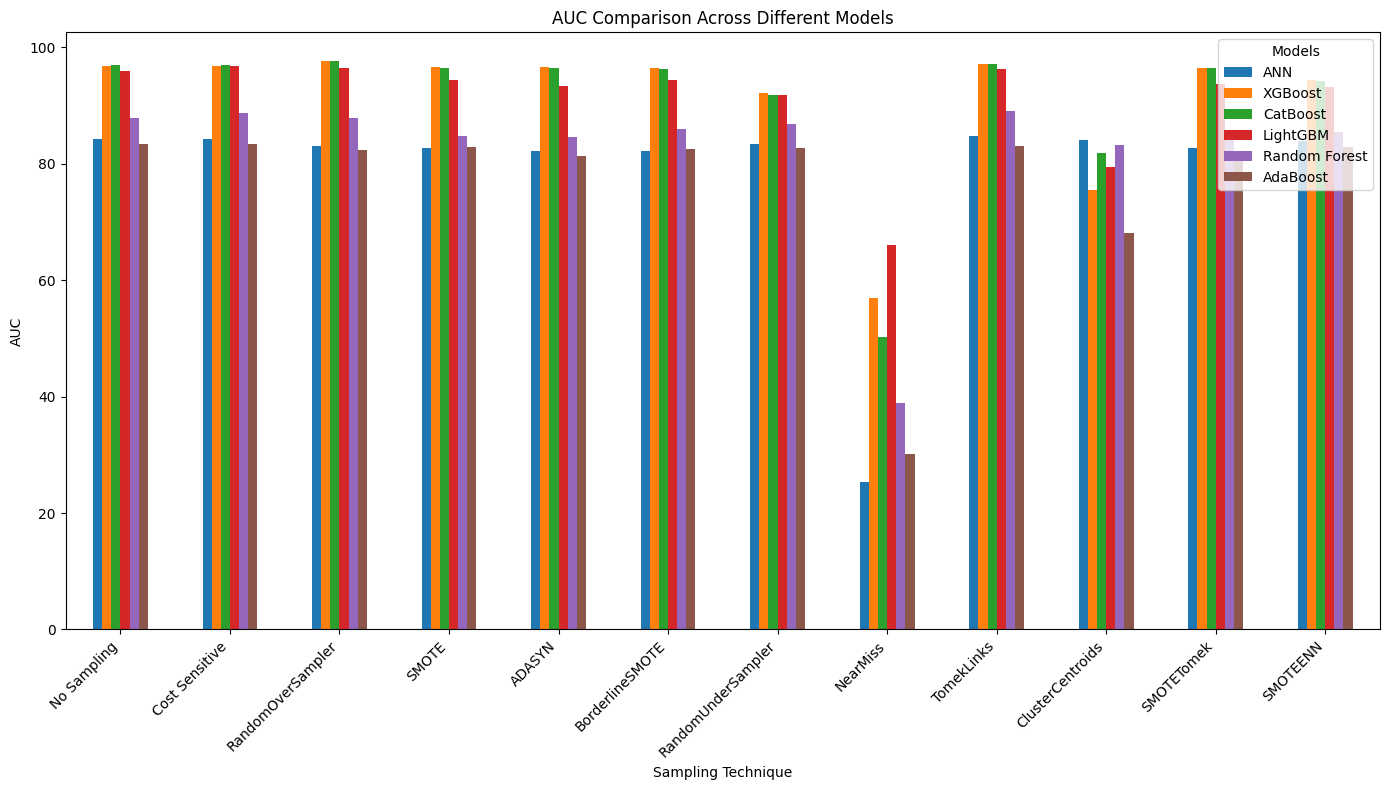

In [55]:
# Extracting the 'AUC' feature
auc_values = {
    "ANN": Ann_df['AUC'],
    "XGBoost": xgb_df['AUC'],
    "CatBoost": cat_df['AUC'],
    "LightGBM": lgbm_df['AUC'],
    "Random Forest": randomForest_df['AUC'],
    "AdaBoost": ada_df['AUC']
}

auc_df = pd.DataFrame(auc_values)

# Plotting
ax = auc_df.plot(kind='bar', figsize=(14, 8))
ax.set_title('AUC Comparison Across Different Models')
ax.set_xlabel('Sampling Technique')
ax.set_ylabel('AUC')
ax.legend(title='Models', loc="upper right")
ax.set_xticklabels(new_index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

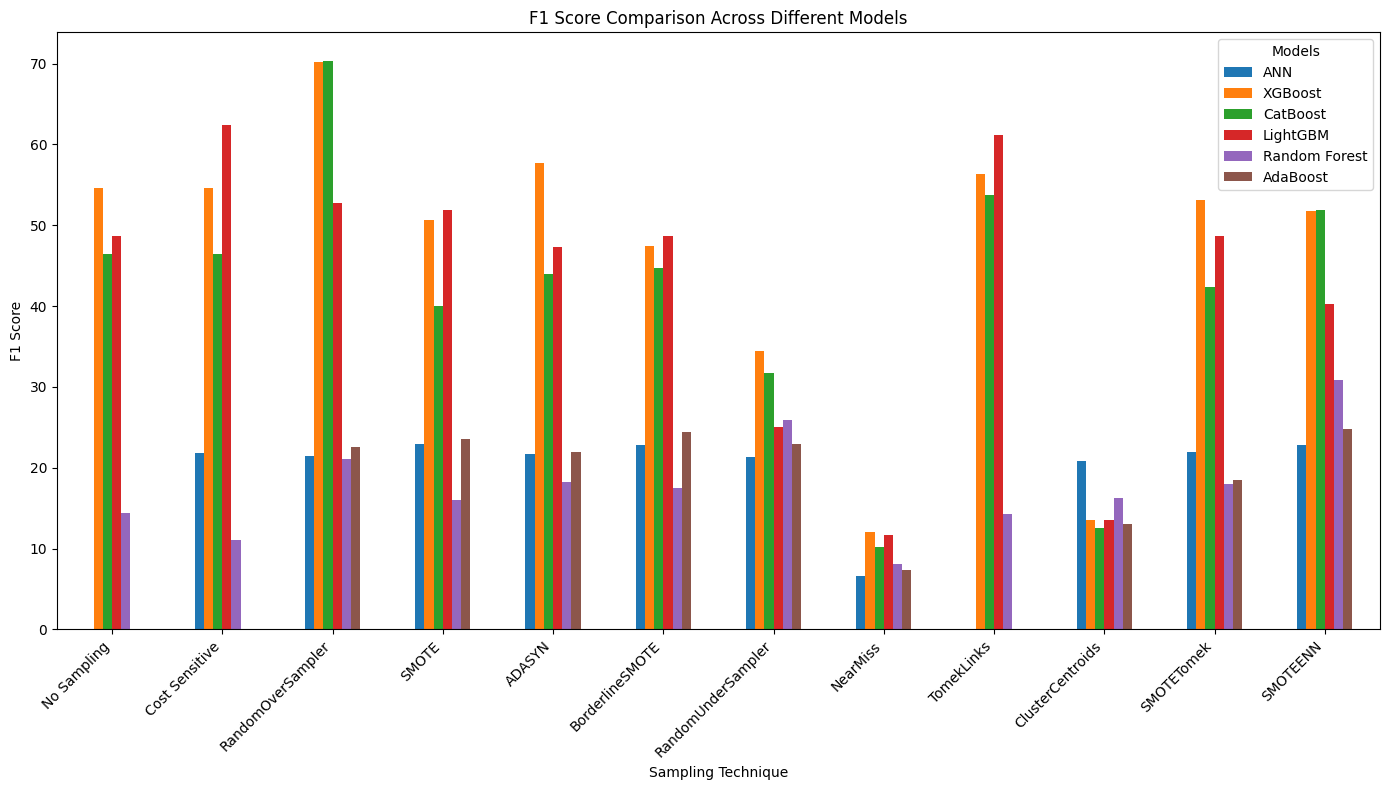

In [52]:
# Extracting the 'F1' feature
F1_values = {
    "ANN": Ann_df['F1 Score'],
    "XGBoost": xgb_df['F1 Score'],
    "CatBoost": cat_df['F1 Score'],
    "LightGBM": lgbm_df['F1 Score'],
    "Random Forest": randomForest_df['F1 Score'],
    "AdaBoost": ada_df['F1 Score']
}

F1_df = pd.DataFrame(F1_values)

# Plotting
ax = F1_df.plot(kind='bar', figsize=(14, 8))
ax.set_title('F1 Score Comparison Across Different Models')
ax.set_xlabel('Sampling Technique')
ax.set_ylabel('F1 Score')
ax.legend(title='Models', loc="upper right")
ax.set_xticklabels(new_index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

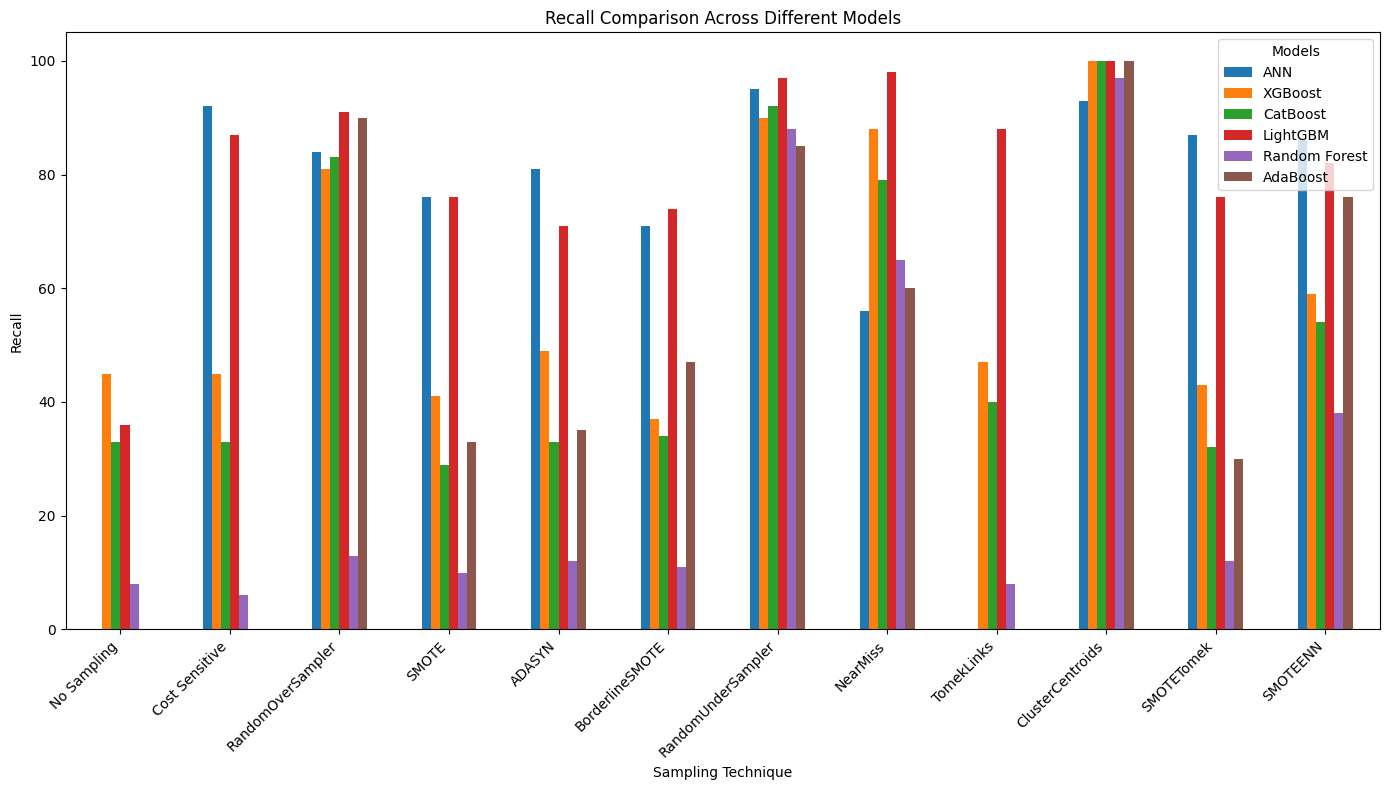

In [49]:
# Extracting the 'Recall' feature
Recall_values = {
    "ANN": Ann_df['Recall'],
    "XGBoost": xgb_df['Recall'],
    "CatBoost": cat_df['Recall'],
    "LightGBM": lgbm_df['Recall'],
    "Random Forest": randomForest_df['Recall'],
    "AdaBoost": ada_df['Recall']
}

Recall_df = pd.DataFrame(Recall_values)

# Plotting
ax = Recall_df.plot(kind='bar', figsize=(14, 8))
ax.set_title('Recall Comparison Across Different Models')
ax.set_xlabel('Sampling Technique')
ax.set_ylabel('Recall')
ax.legend(title='Models', loc="upper right")
ax.set_xticklabels(new_index, rotation=45, ha='right')

plt.tight_layout()
plt.show()
